## Dense Neural Net for Sentiment Classifier

We're going to build a classifier to classify movie reviews

#### Load dependencies

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
#Newly introduced in this chapter
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve

#### Set hyperparameters and constants for the model

In [2]:
output_dir = '../model_files/dense/'
epochs = 4
batch_size = 128

#Hyperparameters
n_emb_size = 64
n_unique_words = 5000
n_words_to_skip = 50

max_review_length = 100
pad_type = trunc_type = 'pre'

n_dense = 64
dropout = 0.5

#### Load our data

In [6]:
(X_train,  y_train), (X_val, y_val) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

17465344/17464789 [==============================] - 32s 2us/step


In [8]:
(X_train_all,  y_train_all), (X_val_all, y_val_all) = imdb.load_data()

In [9]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 9s 6us/step


In [14]:
#Dictionary of Words and their integer indexes
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [30]:
idx_to_word = {i:w for w, i in word_index.items()}
idx_to_word[2]

'UNK'

In [20]:
' '.join(idx_to_word[i] for i in X_train[0])

"and and and and and themselves powerful lets loves their becomes reaching had journalist and lot and anyone and and after and atmosphere never more room and and and heart shows and years and every never going and help moments and and every chest visual and except and and several and enough more and and now current and and and and mine potentially unfortunately and and than him and and and themselves and get and and camp and and and sometimes and and and scary and and and story wonderful and and seeing and character and and 70s and and heart had shadows and and here and and and serious and and does when and why and and critics and and and and isn't and will very and and itself and other and and and seen over and and anyone and and and show's and whether and than and themselves history and name half and and and and odd and two most and mean and 1 any and boat she and should and thought and and and script and and while history and heart and real and and and when and and bit then and two 

In [21]:
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

In [24]:
#Converting word:index dictionary into index:word
index_to_word = {idx: w for w, idx in word_index.items()}

In [25]:
' '.join(index_to_word[i] for i in X_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [26]:
' '.join(index_to_word[i] for i in X_train_all[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Preprocessing the  data

In [36]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_val = pad_sequences(X_val, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [37]:
X_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [38]:
for x in X_train[:6]:
    print(len(x))

100
100
100
100
100
100


In [40]:
' '.join(index_to_word[idx] for idx in X_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [41]:
' '.join(index_to_word[idx] for idx in X_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

#### Neural Net Architecture

In [42]:
model = Sequential()
model.add(Embedding(n_unique_words, n_emb_size, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


#### Compiling model

In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hd5")

In [46]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Fit! Fit! Fit!

In [47]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), \
          callbacks=[model_checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 6s 229us/step - loss: 0.5559 - acc: 0.6913 - val_loss: 0.3590 - val_acc: 0.8416
Epoch 2/4
25000/25000 [==============================] - 5s 181us/step - loss: 0.2802 - acc: 0.8876 - val_loss: 0.3474 - val_acc: 0.8454
Epoch 3/4
25000/25000 [==============================] - 5s 186us/step - loss: 0.1146 - acc: 0.9661 - val_loss: 0.4214 - val_acc: 0.8338
Epoch 4/4
25000/25000 [==============================] - 5s 184us/step - loss: 0.0243 - acc: 0.9958 - val_loss: 0.5271 - val_acc: 0.8339


#### Evaluating and verifying predictions

In [48]:
model.load_weights('../model_files/dense/weights.02.hd5')

In [49]:
yhat = model.predict_proba(X_val)

In [50]:
len(yhat)

25000

In [51]:
yhat[0]

array([0.10069708], dtype=float32)

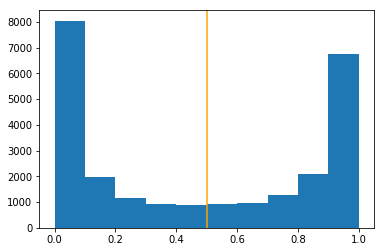

In [52]:
plt.hist(yhat)
_ = plt.axvline(x=0.5, color='orange')

In [56]:
pct_auc = roc_auc_score(y_val, yhat) * 100.0

In [58]:
"{:0.2f}".format(pct_auc)

'92.85'

#### Plotting ROC Curve

In [75]:
fpr, tpr, thresholds = roc_curve(y_val, yhat)

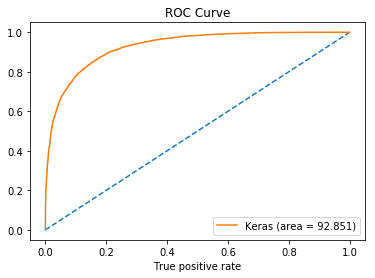

In [89]:
#Plots (x1,x2) & (y1, y2)
plt.plot([0,1],[0,1],'--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(pct_auc))
plt.xlabel("False positive rate")
plt.xlabel("True positive rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [62]:
float_yhat = []
for y in yhat:
    float_yhat.append(y[0])

#### Checking Predictions

In [63]:
df = pd.DataFrame(list(zip(float_yhat, y_val)), columns=['y_hat','y'])

In [64]:
df.head()

,y_hat,y
0,0.100697,0
1,0.980876,1
2,0.787988,1
3,0.555562,0
4,0.997236,1


In [66]:
#Checking if X[0] was indeed a negative review
' '.join(index_to_word[w] for w in X_val_all[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [67]:
#Checking if X[1] was indeed a positive review
' '.join(index_to_word[w] for w in X_val_all[1])

"START this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances austen's the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere rife with sexual tension and psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the solemn moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual repression and desperation be patient 

In [69]:
#Identifying some False positive cases
df[(df.y == 0) & (df.y_hat > 0.9)].head(10)

,y_hat,y
75,0.900813,0
112,0.936575,0
152,0.925801,0
386,0.968040,0
426,0.910892,0
547,0.943694,0
614,0.923534,0
680,0.930178,0
693,0.969913,0
710,0.922585,0


In [70]:
#Checking why it was a False Positive
' '.join(index_to_word[w] for w in X_val_all[386])

"START wow another kevin costner hero movie postman tin cup waterworld bodyguard wyatt earp robin hood even that baseball movie seems like he makes movies specifically to be the center of attention the characters are almost always the same the heroics the flaws the greatness the fall the redemption yup within the 1st 5 minutes of the movie we're all supposed to be in awe of his character and it builds up more and more from there br br and this time the story story is just a collage of different movies you don't need a spoiler you've seen this movie several times though it had different titles you'll know what will happen way before it happens this is like mixing an officer and a gentleman with but both are easily better movies watch to see how this kind of movie should be made and also to see how an good but slightly underrated actor russell plays the hero"

In [71]:
#Identifying some False Negative cases
df[(df.y == 1) & (df.y_hat < 0.1)].head(10)

,y_hat,y
101,0.028753,1
224,0.060102,1
248,0.081750,1
300,0.066136,1
325,0.071316,1
333,0.047711,1
345,0.036591,1
355,0.087225,1
384,0.090850,1
402,0.087544,1


In [72]:
#Checking why it was a False Negative
' '.join(index_to_word[w] for w in X_val_all[101])

"START okul is the first of its kind in turkish cinema and it's way better than i expected those people who say it's neither scary nor funny have a point it's not all that great indeed but it must be kept in mind that everyone involved with the movie is rather amateur so it's basically a maiden voyage and comparing this one to other films such as the 1st class garbage propaganda this movie is pretty damn good br br one thing that must be said it deals with the highschool students' life in turkey very realistically that's exactly how it goes the scenes that are meant to scare are somewhat cheap and hollywoodish most of them even if not all but that religion lesson scene made me laugh in tears and performs the best acting of this flick as a religion teacher br br it's not a waste of your time go and watch it you'll find it rather amusing especially if you know turkey enough to relate to turkish school lives"